In [1]:
import numpy as np
import cv2
from PIL import Image
import scipy.ndimage 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import os
import re
import subprocess
from scipy.ndimage import median_filter

# Блок со всеми используемыми функциями

In [2]:
"""Попробуем реализовать фильтр log + zero-crossing"""
def log_filter(image: np.ndarray) -> np.ndarray:
    """
    Log фильр, возвращает отфильтрованное изоражение
    Параметры:
        image (np.ndarray): изоражение, получаемое на вход для обработки, изображение должно быть в градациях серого!
    Обработка 2х граничных пикселов не будет проводиться.
    """
    kernel_size = 5
    kernel = np.array([0, 0, -1, 0, 0, 0, -1, -2, -1, 0, -1, -2, 16, -2, -1, 0, -1, -2, -1, 0, 0, 0, -1, 0, 0]).reshape(5, 5)
    h, w = image.shape
    filtered_image = np.zeros((h, w))
    # filtered_image = [cv2.filter2D(image, -1, kernel)]
    for row_index in range(2, h - 2):
        for col_index in range(2, w - 2): 
            summ = 0
            for kernel_row in range(kernel_size):
                for kernel_col in range(kernel_size):
                    summ += image[row_index - 2 + kernel_row][col_index - 2 + kernel_col] * kernel[kernel_row][kernel_col]
            filtered_image[row_index][col_index] = summ
    return filtered_image

def linear_filter(image: np.ndarray) -> np.ndarray:
    """
    Линейный фильтры повышения резкости, возвращает отфильтрованное изоражение
    Параметры:
        image (np.ndarray): изоражение, получаемое на вход для обработки
    В фильтре заданный различные свертки, можно написать свою, главное чтобы сумма всех элиментов = 1
    """
    # kernel = np.array([[-1,-1,-1], [-1,16,-1], [-1,-1,-1]]) / 8
    kernel = np.array([[-2,-1,-2], [-1,22,-1], [-2,-1,-2]]) / 10
    # kernel = 0.2 * np.array([0, -1, -1, -1, 0, -1, 1, 1, 1, -1, -1, 1, 9, 1, -1, -1, 1, 1, 1, -1, 0, -1, -1, -1, 0]).reshape(5, 5)
    # kernel = np.array([0, -1, 0, -1, 10, -1, 0, -1, 0]).reshape(3, 3) / 6
    filtered_image = cv2.filter2D(image, -1, kernel)
    return filtered_image

def zero_crossing(image: np.ndarray) -> np.ndarray:
    """
    Для обнаружения границы как бинарного изображения широко
    используется алгоритм поиска пересечения нуля или нулевого уровня
    (zero-crossing).
    Параметры:
        image (np.ndarray): изоражение, получаемое на вход для обработки, отфильтрованное log фильтром. Изображение должно быть в градациях серого!
    """

    h, w = image.shape

    """
    T - автоматический порог для zero-crossing часто так определяют.
    h, w - высота и ширина изображения.
    """

    T = (3 / (4 * w * h)) * np.sum(np.abs(image)) * 20
    # print(T)
    """
    Важный факт - т.к. у нас имеются пороговые пикселы, необходимо определиться для них, как мы будем проводить для них проверку.
    Для этого имеется несколько вариантов:
        1) Добавить граничные пикселы с нулевым значением;
        2) Добавить граничные пикселы со значениями, идентичными анализируемому пикселу;
        3) Не обрабатывать граничные пикселы.
    Граничные пикселы используются только при обработке, в обработанное изображение они не добавляются.
    Мы будем использовать 2й вариант.
    """
    filtered_image = 255 * np.ones((h, w))
    for row_index in range(h):
        for col_index in range(w): 
            """Сравнение с верхним пикселом"""
            try:
                diff_calculation = abs(image[row_index][col_index] - image[row_index + 1][col_index])
                if (diff_calculation >= T) and \
                    (((image[row_index][col_index]) < 0 and (image[row_index + 1][col_index] > 0)) or ((image[row_index][col_index]) > 0 and (image[row_index + 1][col_index] < 0))):
                    filtered_image[row_index][col_index] = 0
            except:
                pass

            """Сравнение с нижним пикселом"""
            try:
                diff_calculation = abs(image[row_index][col_index] - image[row_index - 1][col_index])
                if (diff_calculation >= T) and \
                    (((image[row_index][col_index]) < 0 and (image[row_index - 1][col_index] > 0)) or ((image[row_index][col_index]) > 0 and (image[row_index - 1][col_index] < 0))):
                    filtered_image[row_index][col_index] = 0
            except:
                pass

            """Сравнение с правым пикселом"""
            try:
                diff_calculation = abs(image[row_index][col_index] - image[row_index][col_index + 1])
                if (diff_calculation >= T) and \
                    (((image[row_index][col_index]) < 0 and (image[row_index][col_index + 1] > 0)) or ((image[row_index][col_index]) > 0 and (image[row_index][col_index + 1] < 0))):
                    filtered_image[row_index][col_index] = 0
            except:
                pass

            """Сравнение с левым пикселом"""
            try:
                diff_calculation = abs(image[row_index][col_index] - image[row_index][col_index - 1])
                if (diff_calculation >= T) and \
                (((image[row_index][col_index]) < 0 and (image[row_index][col_index - 1] > 0)) or ((image[row_index][col_index]) > 0 and (image[row_index][col_index - 1] < 0))):
                    filtered_image[row_index][col_index] = 0
            except:
                pass
    return filtered_image

def kmeans_clustering(image: np.ndarray) -> np.ndarray:
    """
    Кластеризация изображения на 2 класса: над фронтом и пож фронтом.
    Параметры:
        image (np.ndarray): изоражение, получаемое на вход для обработки
    Возвращает массив, где ненулевая часть является той, что над фронтом(но на самом деле разницы нет, т.к. нас все равно интересует только граница)
    """
    n_clusters = 2 # т.к. нужно отделить брюки от питжака + фон, то количество кластеров = 3

    KMEANS = KMeans(n_clusters=n_clusters)
    result = KMEANS.fit(image.reshape(-1, 1))

    images = []
    for i in np.unique(result.labels_):
        image_result = np.zeros_like(image)
        # Маски для каждого элемента
        mask = (result.labels_ == i).reshape(image.shape[:])
        image_result[mask] = image[mask]
        images.append(image_result)

    if np.mean(images[0]) == max(np.mean(images[0]), np.mean(images[1])):
        return images[0]
    else:
        return images[1]
    

def create_video_from_images(images_dir: str, image_format: str = 'jpg' , curr_output_dir: str = None, file_name: str = 'output_video'):
    """
    Функция ,которая объединяет фотографии в видиофайл с расширением avi.
    Параметры:
        images_dir (str): директория, из которой используются файлы для создания видиофайла;
        image_format (str): расширение для используемых изображений, по умолчанию jpg; 
        curr_output_dir (str): директория, в котору будет запиисан итоговый файл, по умолчанию запись идет в ту же директорию, в котором находится файл программы;
        file_name: (str): название выходного файла, по умолчанию называется output_video.
    """
    # Задаем пути к директориям
    output_file = file_name + '.avi'
    if curr_output_dir is not None:
        output_file = os.path.join(curr_output_dir, file_name)
        # Проверяем существование директорий
        if not os.path.exists(curr_output_dir):
            print(f"{curr_output_dir} does not exist, directory created.")
            os.makedirs(curr_output_dir)
    else: 
        pass

    # # Проверяем существование директорий
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Directory with images '{images_dir}' not found.")
    
    # Формируем команду для ffmpeg
    ffmpeg_command = [
        'ffmpeg',
        '-framerate', '25',  # Частота кадров
        '-i', os.path.join(images_dir, 'image_%d.' + image_format),  # Шаблон имени файлов
        '-c:v', 'rawvideo',  # Кодек видео для несжатого формата
        '-pix_fmt', 'yuv420p',  # Формат пикселей для совместимости
        output_file
    ]

    # Выполняем команду ffmpeg
    try:
        subprocess.run(ffmpeg_command, check=True)
        print(f"Видео успешно создано:")
    except subprocess.CalledProcessError as e:
        print(f"Ошибка при выполнении команды ffmpeg: {e}")
    except Exception as e:
        print(f"Произошла ошибка: {e}")



def read_video_file(video_name: str, input_directory: str = None, output_direcoty: str = None, format: str = 'jpg'):
    """
    Чтение видеофайла и запись каждого кадра как изображения.
    Параметры:
        video_name (str): название видеофайла из которого читаются кадры;
        input_directory (str): название директории из которой происходит чтение файла, по умолчанию читает из той же, где находится программа;
        output_direcoty (str): название директории в которую идет запись кадров, по умолчанию читает из той же, где находится программа;
        format (str): формат, в котором буду записаны изображения, по умолчанию jpg.
    """
    full_name = input_directory + '/' + video_name
    if not os.path.exists(output_direcoty):
        os.makedirs(output_direcoty)
        print('Directory ' + output_direcoty + 'created')

    vidcap = cv2.VideoCapture(full_name)
    success, image = vidcap.read()
    count = 1
    while success:
        cv2.imwrite(output_direcoty+ f"/image_{count}." + format, image)    
        success, image = vidcap.read()
        if count % 100 == 0:
            print('Saved image ', count)
        count += 1

# Основная часть

In [4]:
"""
Модуль для записи изоображений из видио файлов
"""
video_file_name = '0.715_5.10.avi'
output_dir = 'video_data'
formation = 'jpg'
if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print('Directory ' + output_dir + 'created')

vidcap = cv2.VideoCapture(video_file_name)
success, image = vidcap.read()
count = 1
while success:
    cv2.imwrite(output_dir+ f"/image_{count}." + formation, image)    
    success, image = vidcap.read()
    if count % 100 == 0:
        print('Saved image ', count)
    count += 1

Saved image  100
Saved image  200
Saved image  300
Saved image  400
Saved image  500
Saved image  600
Saved image  700
Saved image  800
Saved image  900
Saved image  1000


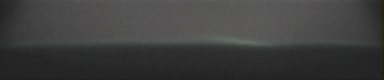

In [5]:
rangom_image = Image.open(output_dir+ f"/image_{10}." + formation)
rangom_image

In [6]:
"""С фильтрацией изображений"""
output_dir = 'video_data'
source_directory = output_dir
final_directory = 'front_filtered_bilateral_3linear_median'

if not os.path.exists(final_directory):
        os.makedirs(final_directory)
        print('Directory ' + final_directory + 'created')

    
numbers_of_images = np.sort(np.array([re.findall('[0-9]+', im)[0] for im in sorted(os.listdir(source_directory))], dtype=int))
for im in numbers_of_images:
    if im % 100 == 0:
        print(f'{im} images computed')
    source_path = source_directory + '/' + f'image_{im}.jpg'
    current_image = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
    # Предфильтрация
    current_image = cv2.bilateralFilter(current_image, 15, 50, 50)    
    current_image = linear_filter(current_image)
    current_image = linear_filter(current_image)
    current_image = linear_filter(current_image)
    
    median_filtered_image = median_filter(current_image, size=20) 
    current_image = kmeans_clustering(median_filtered_image)
    current_image = log_filter(current_image)
    current_image = zero_crossing(current_image)
    final_path = final_directory + '/' + f'image_{im}.jpg'
    cv2.imwrite(final_path, current_image) 
print('Computation complete')

100 images computed
200 images computed
300 images computed
400 images computed
500 images computed
600 images computed
700 images computed
800 images computed
900 images computed
1000 images computed
Computation complete


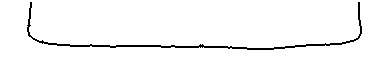

In [7]:
rangom_image = Image.open(final_directory + '/' + f'image_{10}.jpg')
rangom_image

In [8]:
"""Без фильтрации изображений"""
source_directory = output_dir
final_directory = 'front'

if not os.path.exists(final_directory):
        os.makedirs(final_directory)
        print('Directory ' + final_directory + 'created')

numbers_of_images = np.sort(np.array([re.findall('[0-9]+', im)[0] for im in sorted(os.listdir(source_directory))], dtype=int))
for im in numbers_of_images:
    if im % 100 == 0:
        print(f'{im} images computed')
    source_path = source_directory + '/' + f'image_{im}.jpg'
    current_image = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
    current_image = kmeans_clustering(current_image)
    current_image = log_filter(current_image)
    current_image = zero_crossing(current_image)
    final_path = final_directory + '/' + f'image_{im}.jpg'
    cv2.imwrite(final_path, current_image) 

100 images computed
200 images computed
300 images computed
400 images computed
500 images computed
600 images computed
700 images computed
800 images computed
900 images computed
1000 images computed


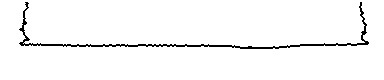

In [9]:
rangom_image = Image.open(final_directory + '/' + f'image_{10}.jpg')
rangom_image

In [ ]:
"""Формирование из изображений видиофайла"""
create_video_from_images(images_dir='front_filtered_bilateral_3linear_median', file_name='output_video_new')

# Вычисление длины фронта

In [10]:
source_directory = 'front_filtered_bilateral_3linear_median'
source_path = source_directory + '/' + f'image_{123}.jpg'
current_image = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

[]

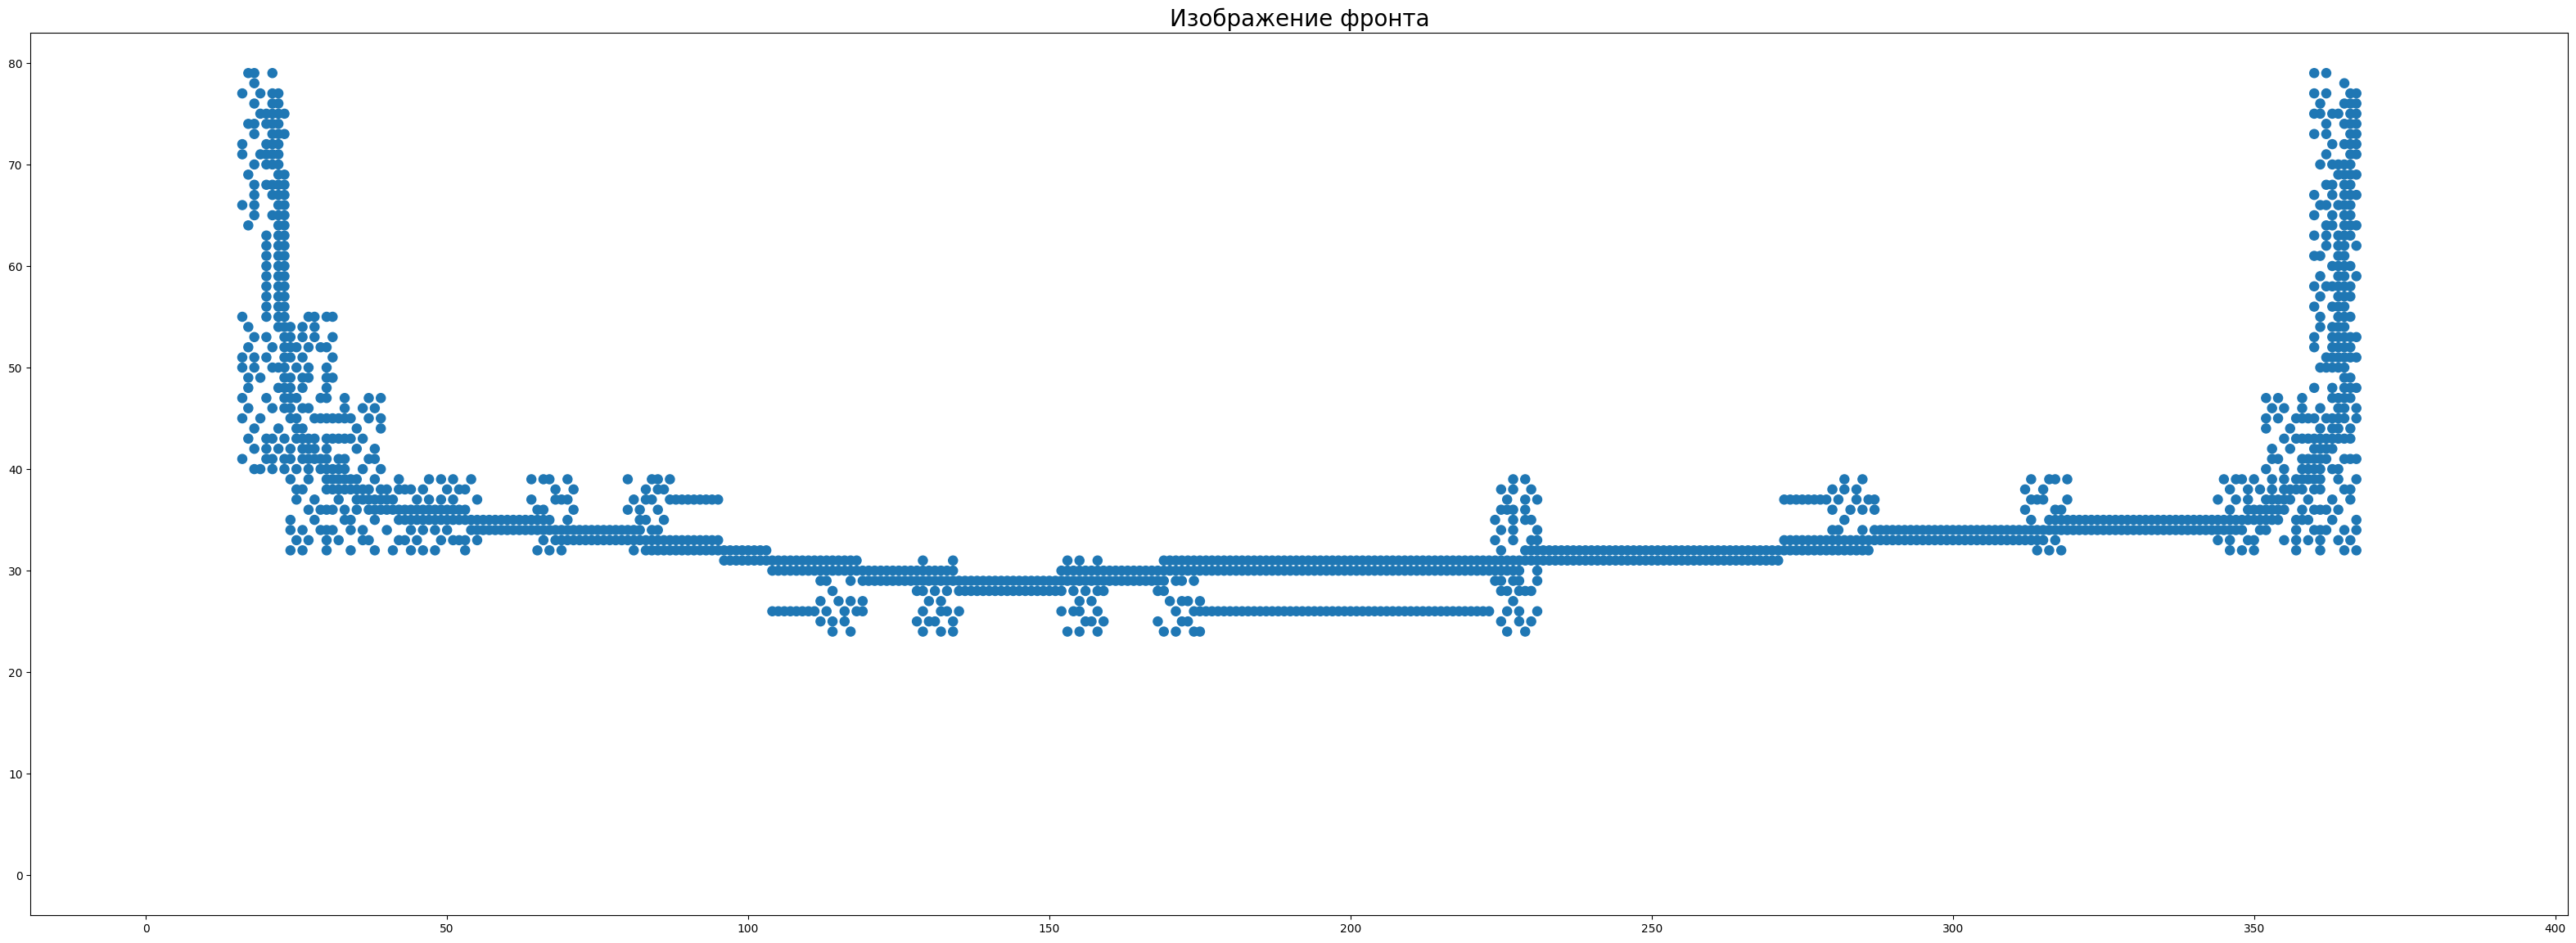

In [11]:
visualization_data = [[0 if j == 255 else 255 for j in i]for i in current_image]
y_range, x_range = current_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14)) 
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Изображение фронта', fontdict={'fontsize':20})
plt.plot()

# Порпобуем использовать алгоритмы утоньшения для того, чтобы получить более четкую границу

In [12]:
"""
В качестве алгоритма утоньшения можно использовать следующие: алгоритм Рутовица, алгоритм Хилдича, алгоритм Ахмеда-Варда.
Воспользуемся алгоритмом Хилдича
"""

def GatherNeighbors(x: int, y:int, picture_shape: tuple, bool_current_image: list[list[int]]) -> list[int]:
    """
    Возвращает значения пикселов вокруг ислледуемого.
    Параметры: 
        x (int): координата x исследуемого пиксела;
        y (int): координата y исследуемого пиксела;
        picture_shape (tuple): размерность изображения;
        bool_current_image (list[list[int]]): массив значений пикселов.

    Индексы соседей:
    7 0/8 1
    6  *  2
    5  4  3
    """
    neibor_values = [0] * 8
    neibor_iindexes = ((0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1))
    for position, i in zip(neibor_iindexes, range(len(neibor_values))):
        x_delta = x + position[0]
        y_delta = y + position[1]
        if x_delta >= 0 and x_delta < picture_shape[1] and y_delta >= 0 and y_delta < picture_shape[0]:
            # print(y_delta, x_delta, y_delta * picture_shape[1] + x_delta)
            neibor_values[i] = bool_current_image[y_delta][x_delta]
        else:
            pass
    return neibor_values


def RutovitzNumber(neibor_values: list[int]) -> int:
    """
    Вычисление числа пересечений Рутовица
    """
    number = 0
    for i in range(len(neibor_values) - 1):
        number += abs(neibor_values[i] - neibor_values[i + 1])
    # number += abs(neibor_values[0] - neibor_values[len(neibor_values) - 1])
    return number


def ThinRutovitzIteration(x: int, y:int, picture_shape: tuple, bool_current_image: list[list[int]]) -> bool:
    """
    Функция определяет, подлежит ли пиксел удалению
    Параметры: 
        x (int): координата x исследуемого пиксела;
        y (int): координата y исследуемого пиксела;
        picture_shape (tuple): размерность изображения;
        bool_current_image (list[list[int]]): массив значений пикселов.
    """
    
    neibor_values = GatherNeighbors(x=x, y=y, picture_shape=picture_shape, bool_current_image=bool_current_image)


    b = 0
    for value in neibor_values:
        b += value

    # if b < 2 or b > 7: # Проверка на 2е и 3е условие на удаление пиксела
    #     return False
    
    Nr = RutovitzNumber(neibor_values=neibor_values)
    r1 = neibor_values[0] * neibor_values[2] * neibor_values[4]
    r2 = neibor_values[0] * neibor_values[2] * neibor_values[6]

    if Nr == 2 and r1 == 0 and r2 == 0 and b > 1 and b < 7:
        return True
    
    return False


def ThinRutovitz(image_data: list[int]) -> np.ndarray:
    """
    Алгоритм Рутовица.
    Параметры:
        image_data (list[int]): массив пикселов изображения.
    """
    bool_current_image = np.array([[0 if j == 255 else 1 for j in i]for i in image_data])
    rows, cols = bool_current_image.shape
    mask_data = [[False] * cols] * rows
    # bool_current_image_copy = bool_current_image.copy()
    isChanged = True
    itter = 0
    while isChanged:
        isChanged = False
        for row in range(rows):
            for col in range(cols):
                if bool_current_image[row][col] == 1: # проверка того, что пиксел пренадлежит объекту
                    flag = ThinRutovitzIteration(x=col, y=row, picture_shape=bool_current_image.shape, bool_current_image=bool_current_image)
                    if flag:
                        mask_data[row][col] = True
                        isChanged = True
                
        if isChanged:
            # bool_current_image[mask_data] = 0
            for row in range(rows):
                for col in range(cols):
                    if mask_data[row][col]:
                        bool_current_image[row][col] = 0
            mask_data = [[False] * cols] * rows
        isChanged = False
            # X_data, Y_data = np.meshgrid(cols, rows)
            # figure, axis = plt.subplots(1, 1, figsize=(40, 14)) 
            # axis.scatter(x=X_data, y=Y_data, s=bool_current_image * 255, marker ='.')
            # axis.set_title('Перевернутое изображение фронта', fontdict={'fontsize':20})
            # plt.plot()
        

    return np.array([[255 if j == 0 else 0 for j in i]for i in bool_current_image])

In [13]:
result_image = ThinRutovitz(current_image)

[]

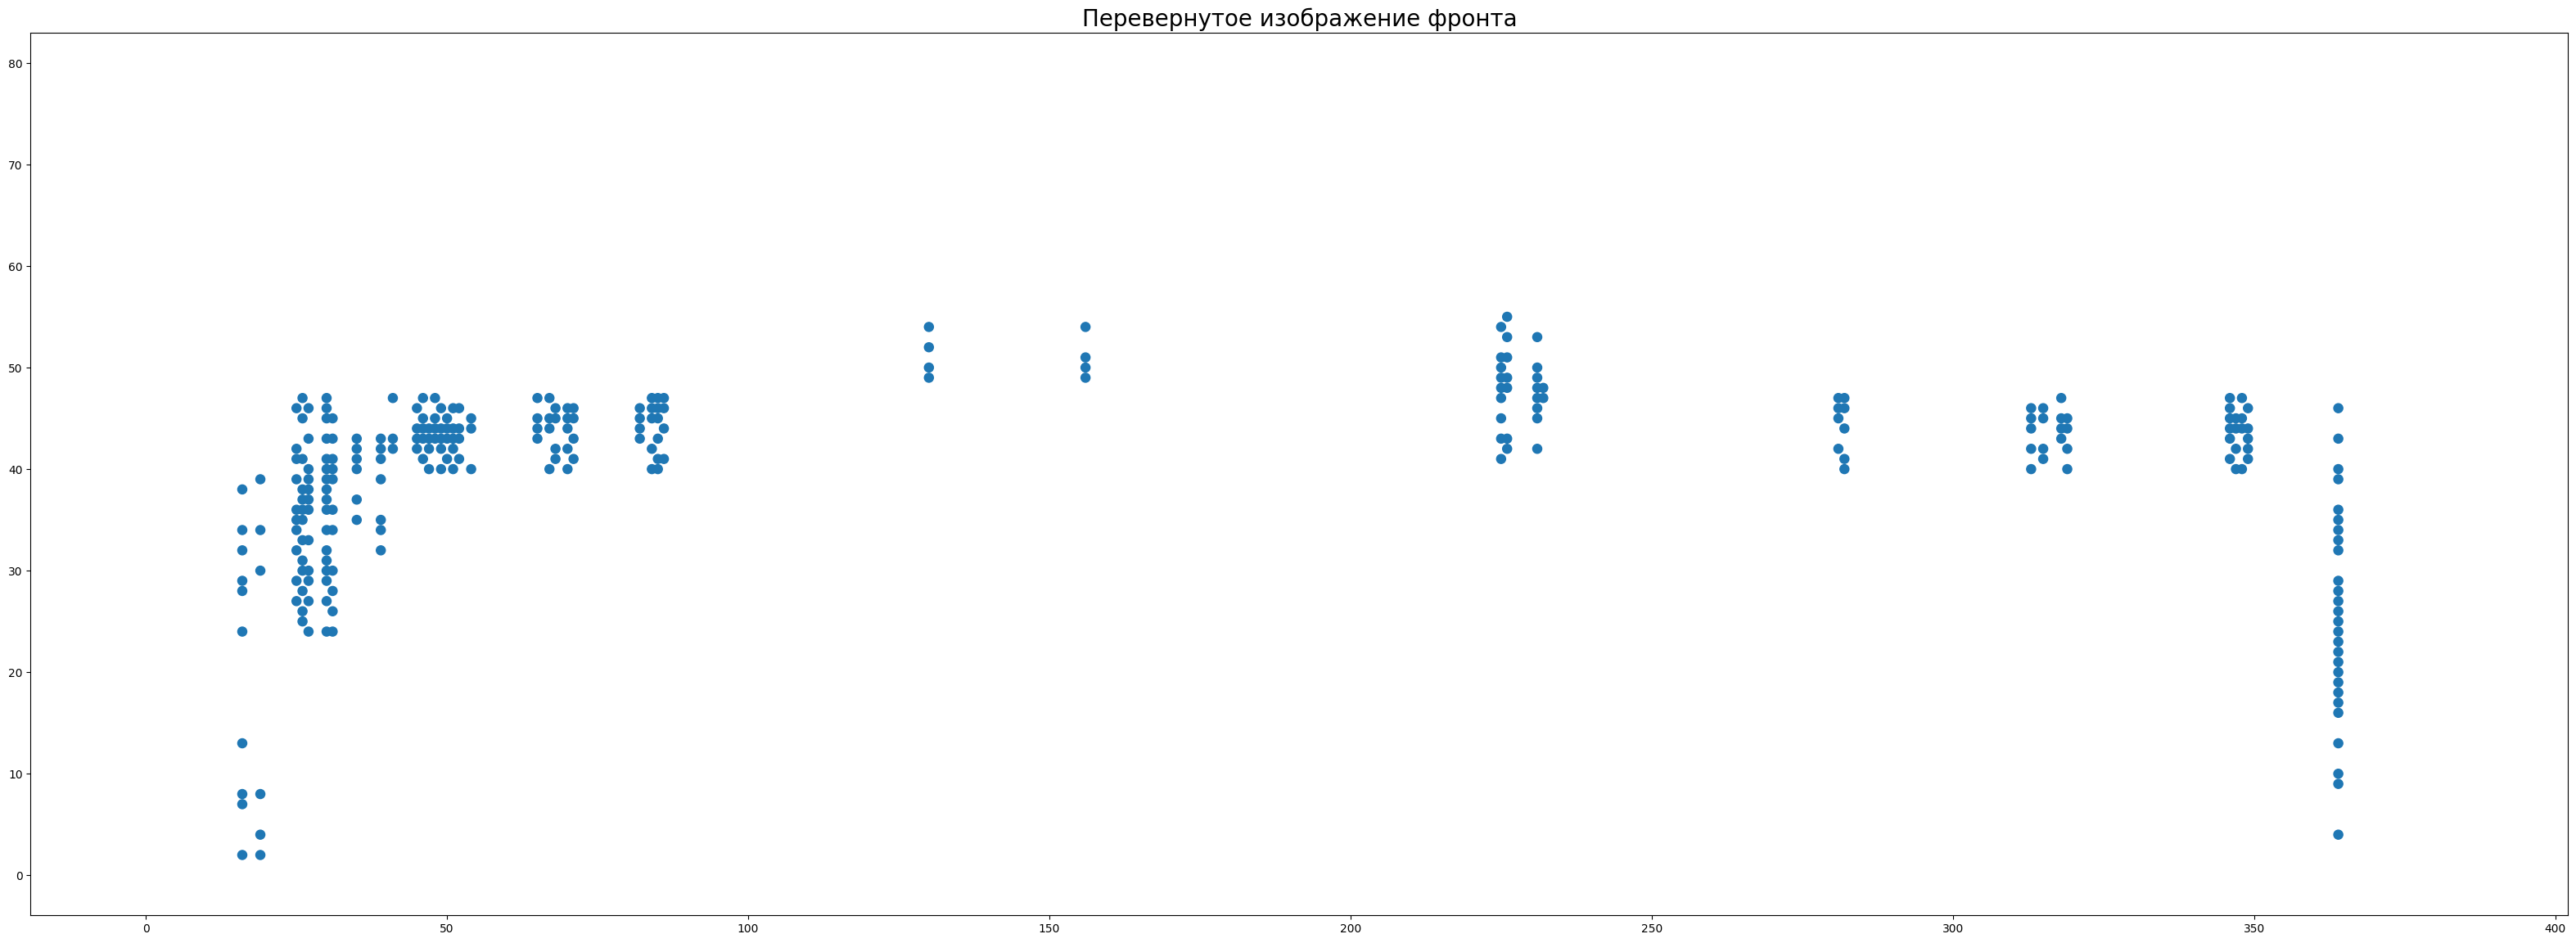

In [14]:
mask_visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in current_image])
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14)) 
# axis.scatter(x=x_data, y=y_data, s=visualization_data - mask_visualization_data, marker ='.')
axis.scatter(x=x_data, y=y_data, s=mask_visualization_data, marker ='.')
axis.set_title('Перевернутое изображение фронта', fontdict={'fontsize':20})
plt.plot()

In [19]:
"""
Попробуем пройтись сверткой 
0 1 0
1 0 1
0 1 0
Если значение свертки < threshold, то зануляем пиксел
"""

def matrix_mask_result(x: int, y:int, picture_shape: tuple, bool_current_image: list[list[int]]) -> bool:
    """
    Применение свертки, зануление элементов с порогом меньше 4
    Параметры: 
        x (int): координата x исследуемого пиксела;
        y (int): координата y исследуемого пиксела;
        picture_shape (tuple): размерность изображения;
        bool_current_image (list[list[int]]): массив значений пикселов.

    Индексы соседей:
    7 0/8 1
    6  *  2
    5  4  3
    """
    value = 0
    neibor_values = [1, 0, 1, 0, 1, 0, 1, 0]
    neibor_indexes = ((0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1))
    for position, i in zip(neibor_indexes, range(len(neibor_values))):
        x_delta = x + position[0]
        y_delta = y + position[1]
        if x_delta >= 0 and x_delta < picture_shape[1] and y_delta >= 0 and y_delta < picture_shape[0]:
            value += bool_current_image[y_delta][x_delta] * neibor_values[i]
        else:
            pass
    # if value < 2:
    #     return True
    # return False
    return value

def mask_algoritm(image_data: list[list[int]], threshold: int = 1, repeat_number: int = 1) -> np.ndarray:
    """
    Преобразование изображения в результате свертки.
    Параметры:
        image_data (list[int]): массив пикселов изображения;
        threshold (int): пороговое значение, количество значимых соседей.
    """
    bool_image = np.array([[0 if j == 255 else 1 for j in i]for i in image_data])
    rows, cols = bool_image.shape
    # new_bool_image = np.zeros((rows, cols))
    while repeat_number > 0:
        new_bool_image = np.zeros((rows, cols))
        for row in range(rows):
            for col in range(cols):
                if bool_image[row][col] == 1: # проверка того, что пиксел пренадлежит объекту
                    if matrix_mask_result(x=col, y=row, picture_shape=bool_image.shape, bool_current_image=bool_image) > threshold:
                        new_bool_image[row][col] = 1
        bool_image = new_bool_image.copy()
        repeat_number -= 1

    # return new_bool_image
    return np.array([[255 if j == 0 else 0 for j in i]for i in bool_image])

[]

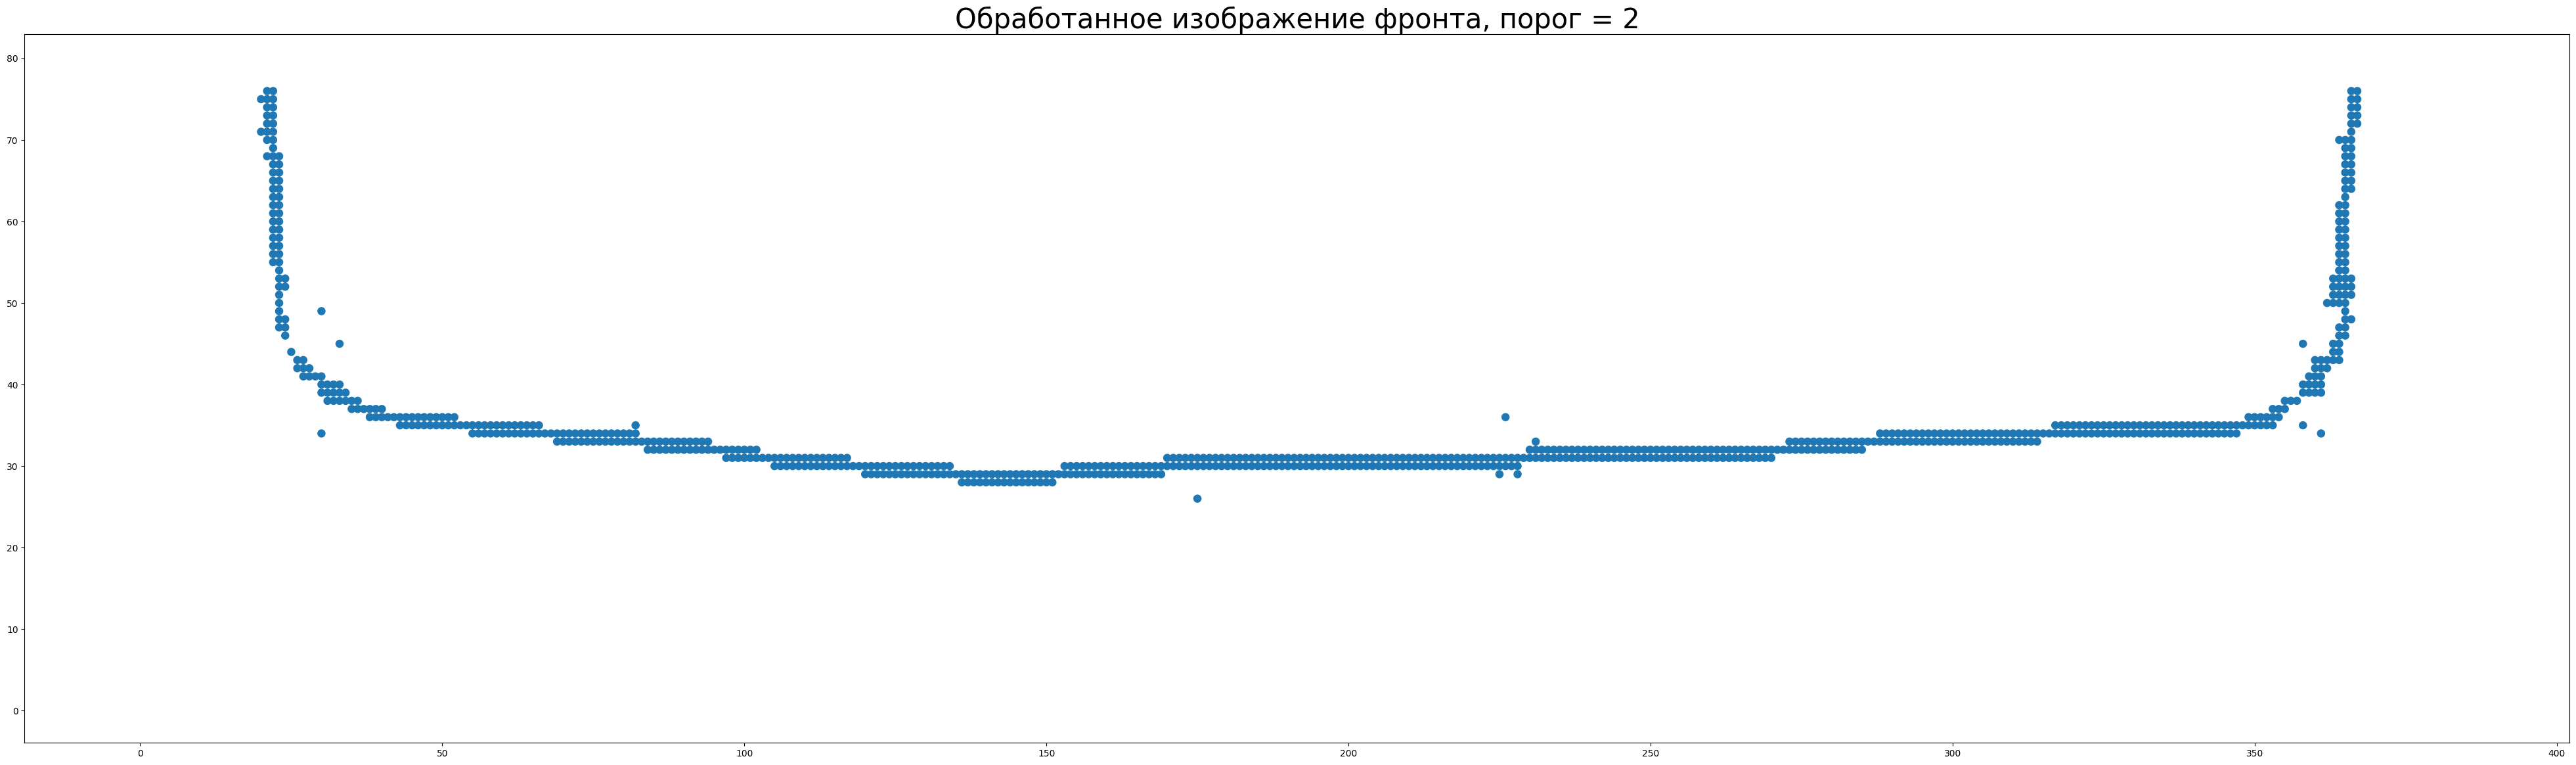

In [21]:
result_image = mask_algoritm(current_image, threshold=2)
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(50, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Обработанное изображение фронта, порог = 2', fontdict={'fontsize':30})
plt.plot()


[]

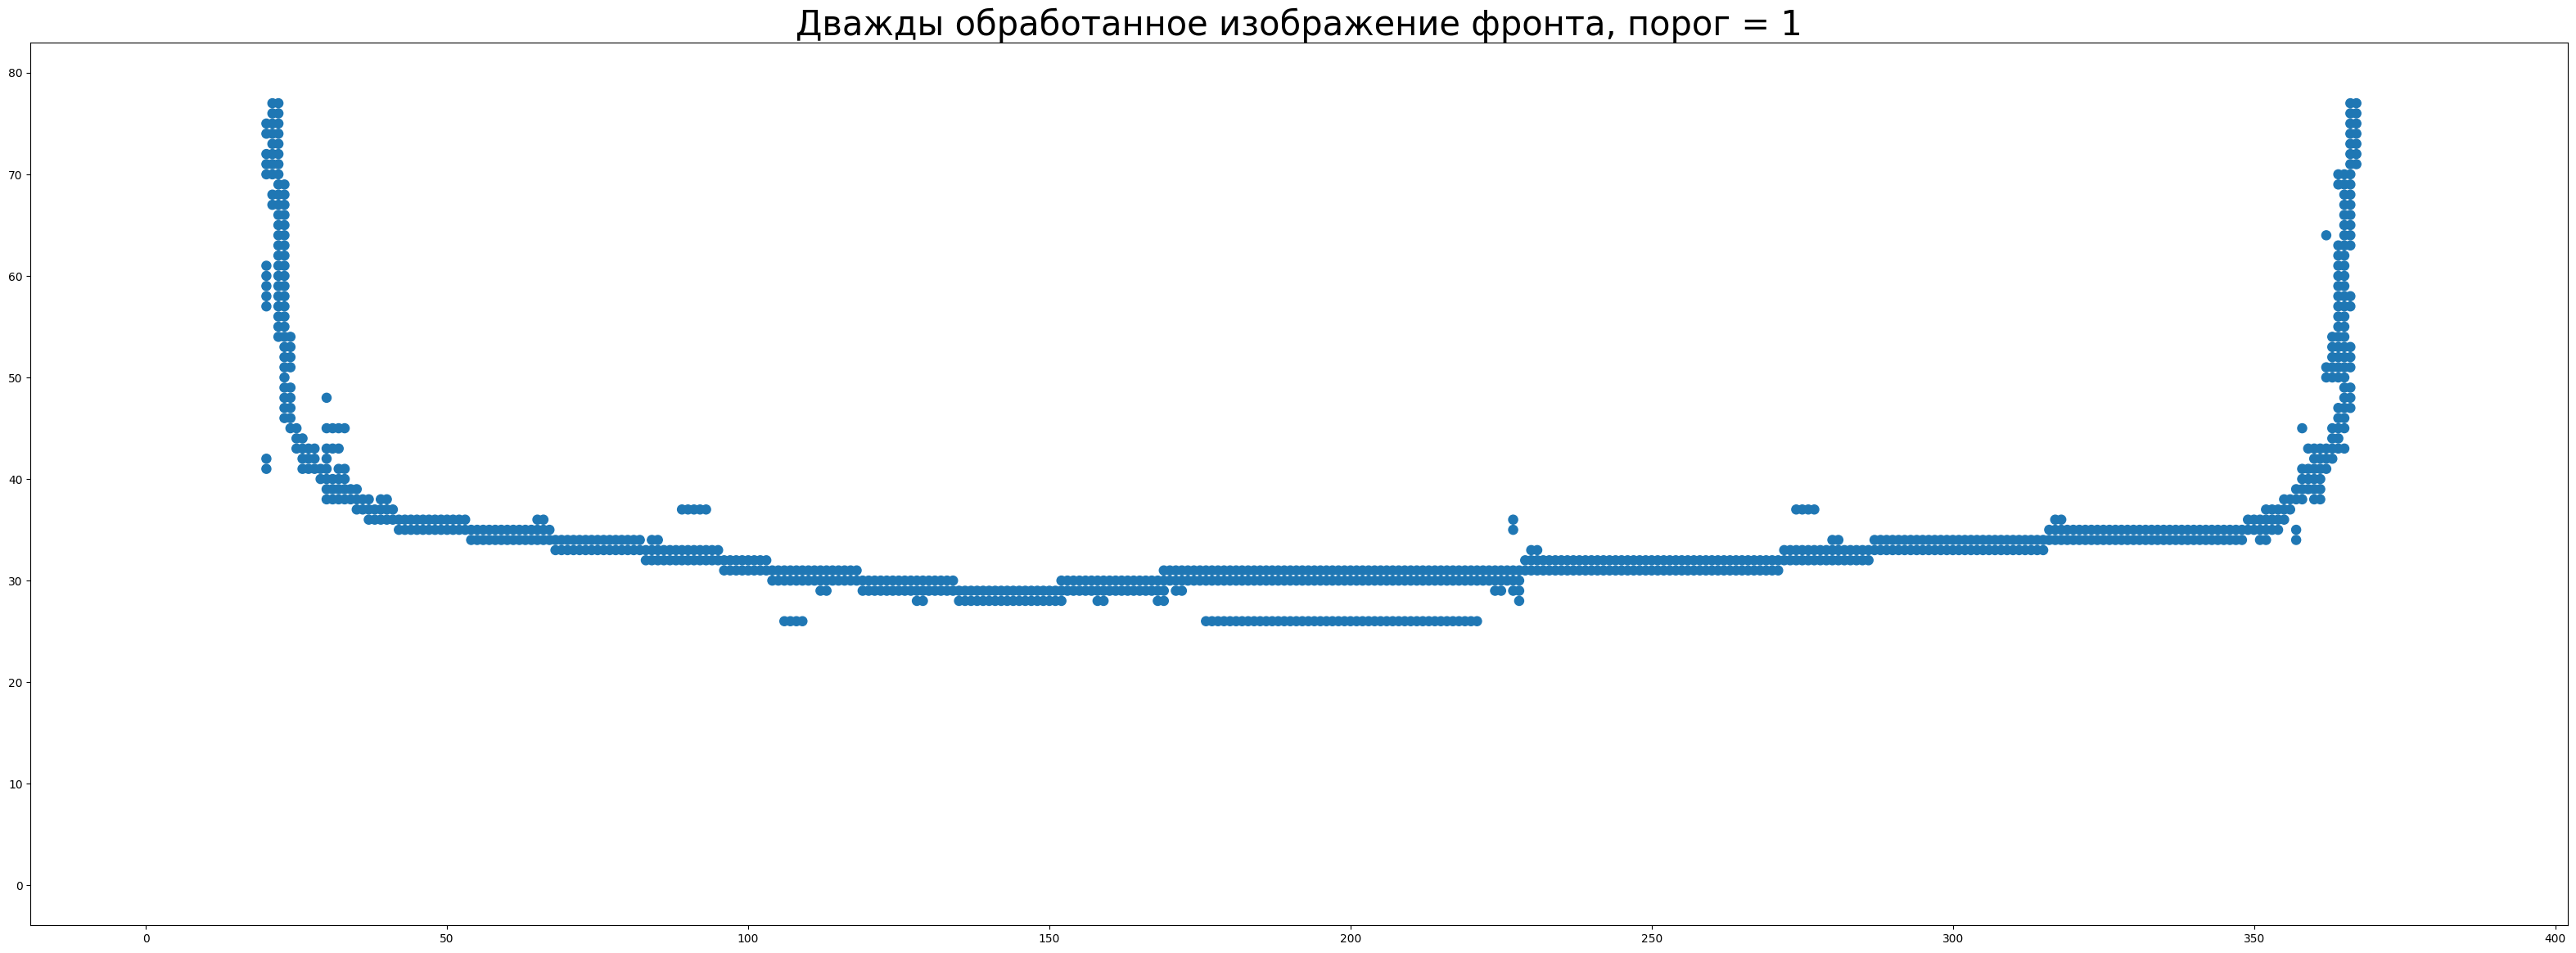

In [22]:
result_image = mask_algoritm(current_image, threshold=1, repeat_number=2)
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Дважды обработанное изображение фронта, порог = 1', fontdict={'fontsize':30})
plt.plot()

[]

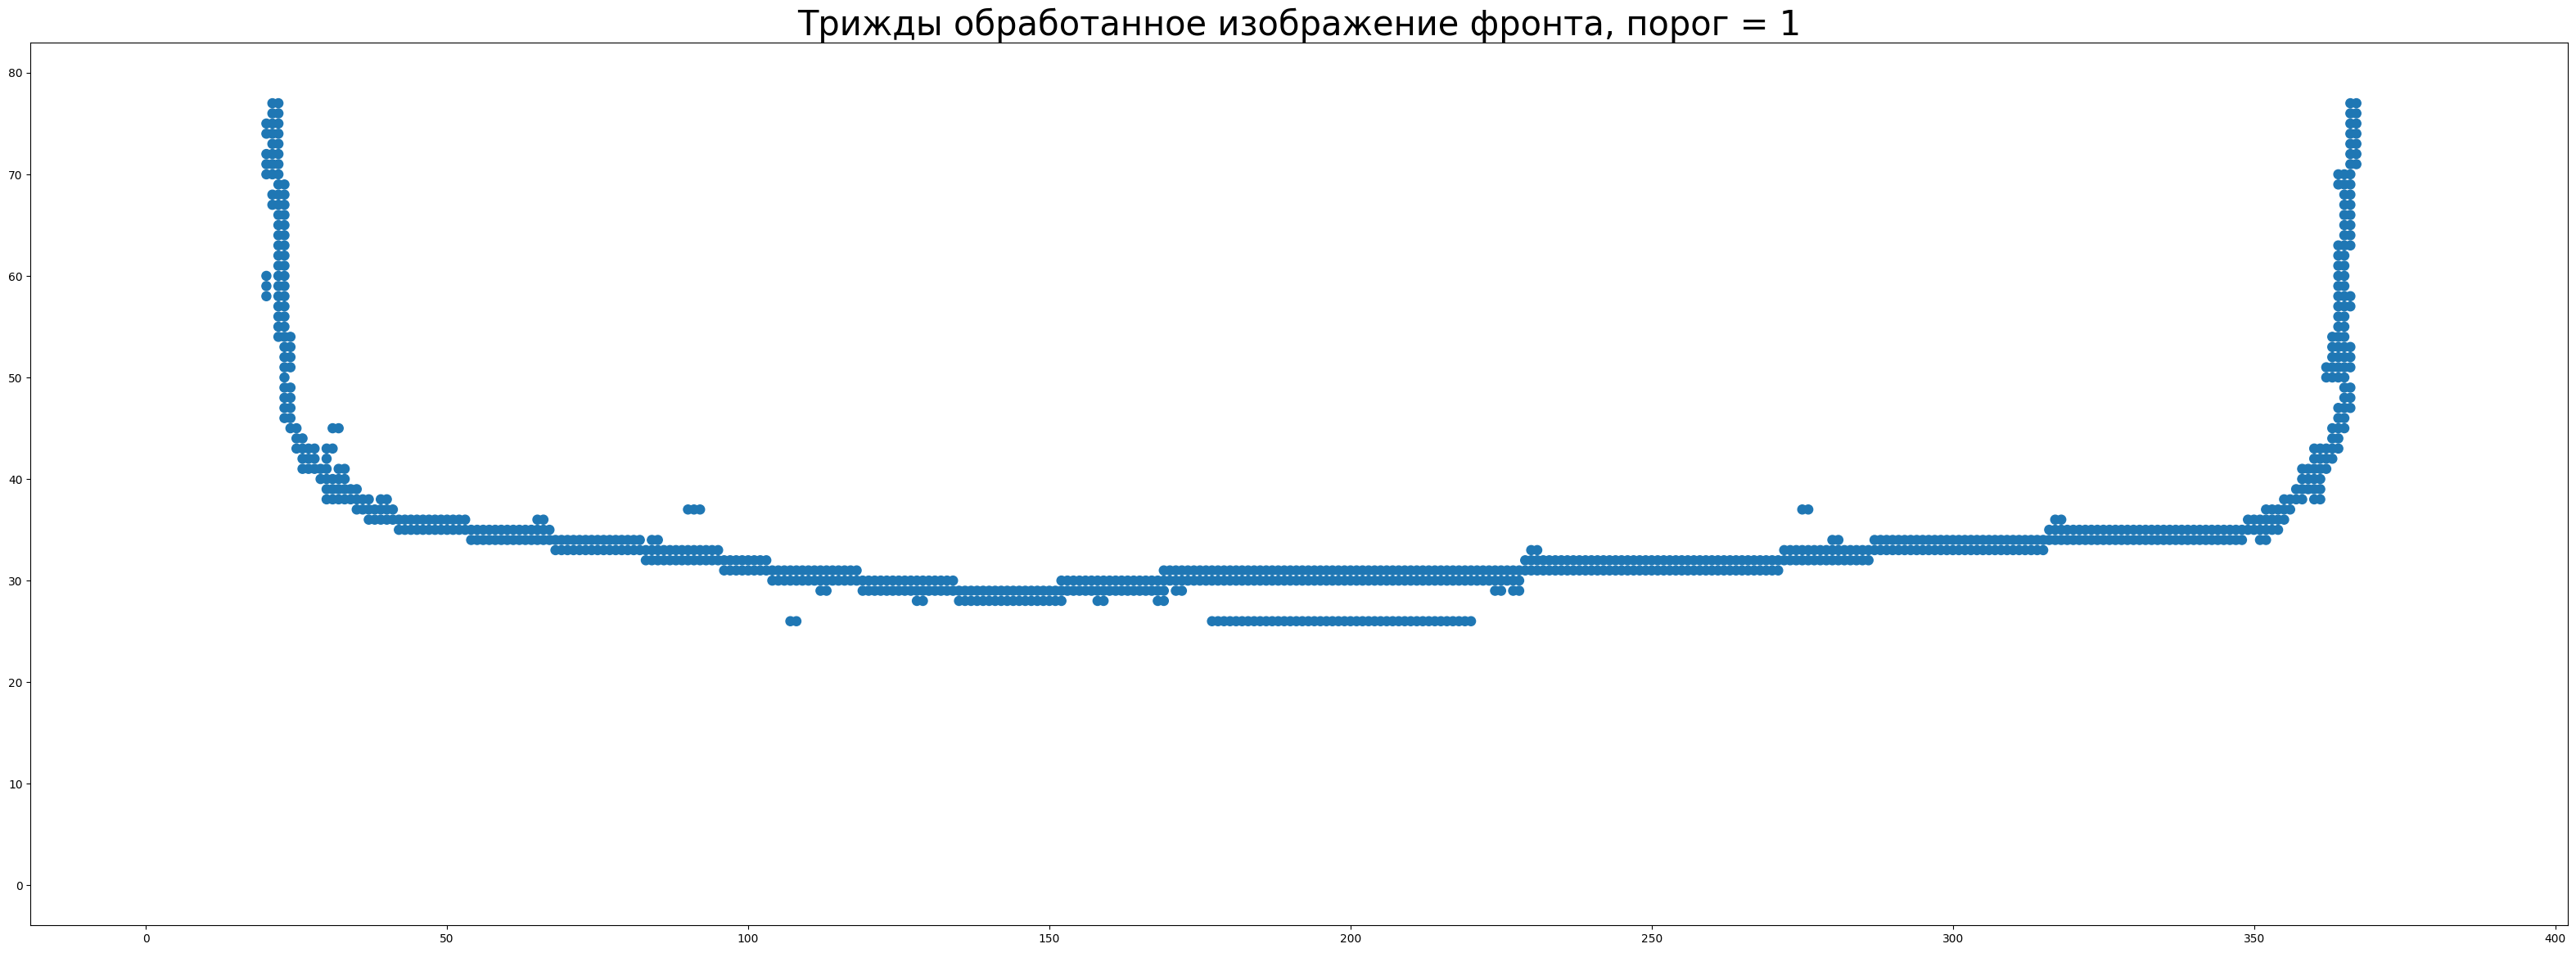

In [24]:
result_image = mask_algoritm(current_image, threshold=1, repeat_number=3)
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Трижды обработанное изображение фронта, порог = 1', fontdict={'fontsize':30})
plt.plot()

[]

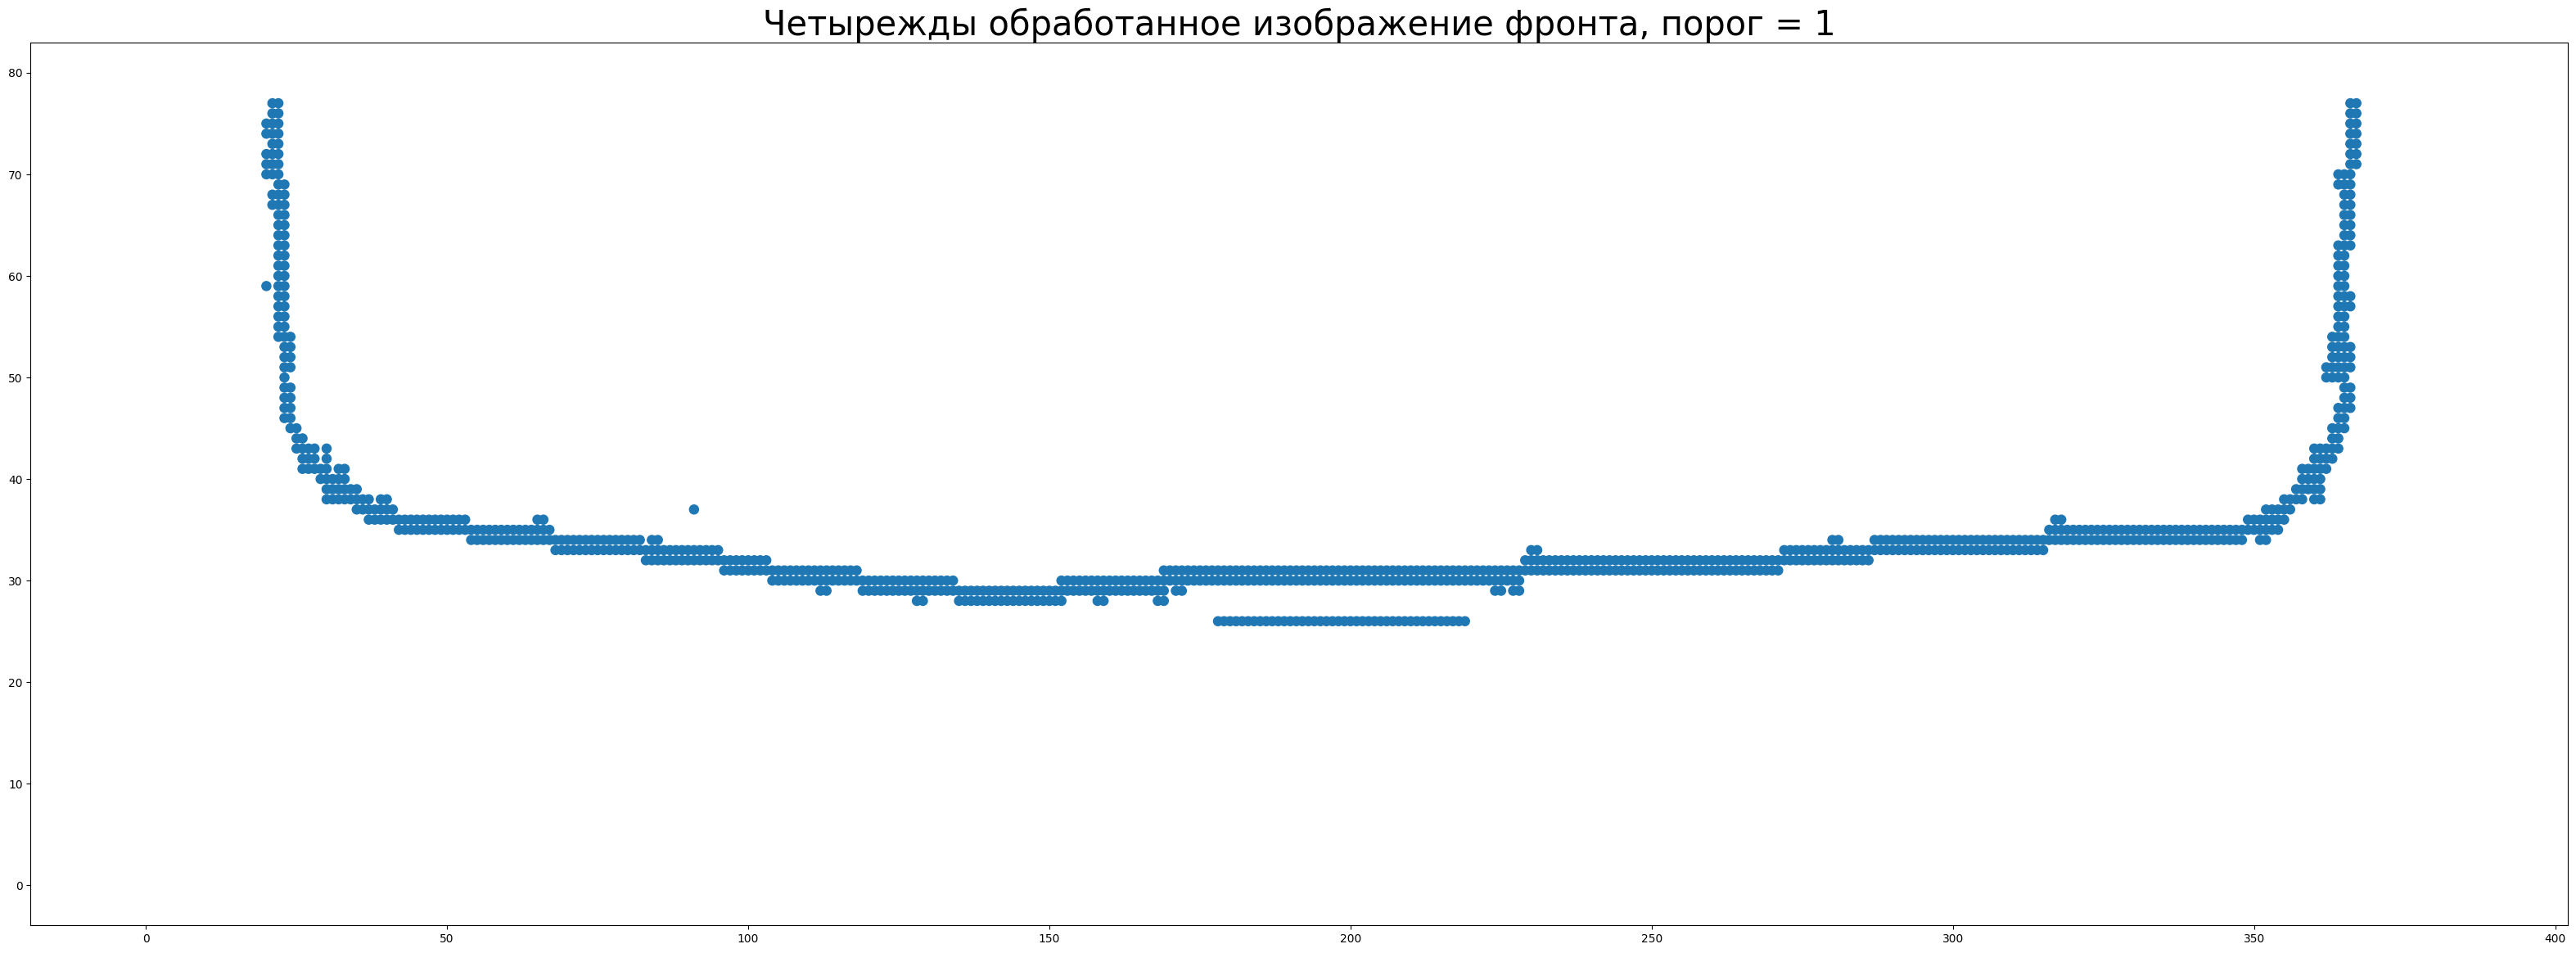

In [25]:
result_image = mask_algoritm(current_image, threshold=1, repeat_number=4)
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Четырежды обработанное изображение фронта, порог = 1', fontdict={'fontsize':30})
plt.plot()

[]

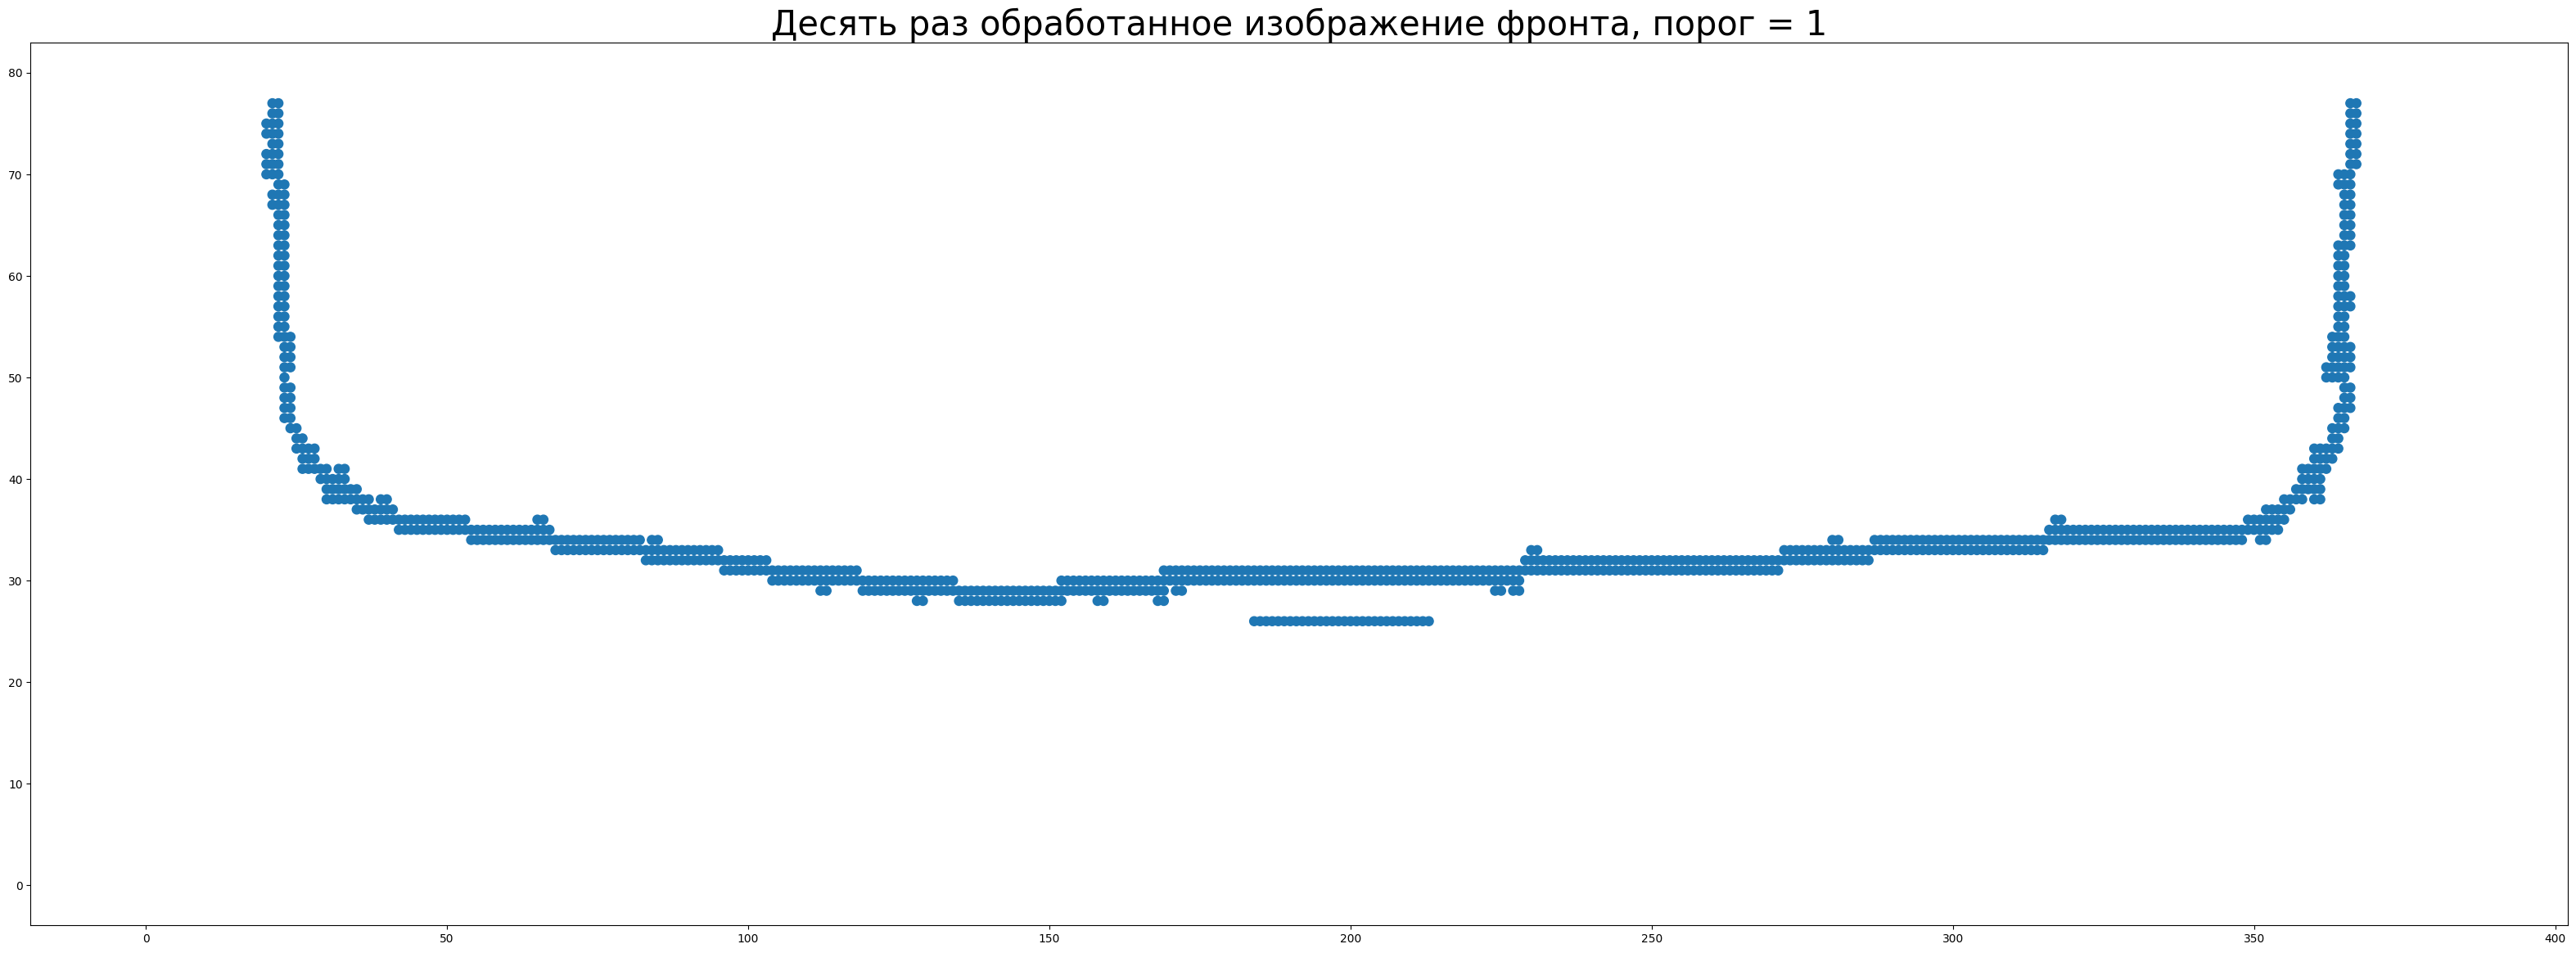

In [26]:
result_image = mask_algoritm(current_image, threshold=1, repeat_number=10)
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Десять раз обработанное изображение фронта, порог = 1', fontdict={'fontsize':30})
plt.plot()

In [33]:
def find_start_stop(image_data: np.ndarray) -> list[tuple]:
    """
    Функция для нахождения пикселов начала и конца фронта.
    Возвращает список в следующей последовательности пикселов [start, stop].
    Параметры:
        image_data (list[list[int]]): массив пикселов изображения;
    Здесь значения 0 у пиксела означает, что он является частью фронта, т.е. интересует нас.
    """
    start_flag = True
    stop_flag = True
    start_pos = (0, 0)
    stop_pos = ()

    rows, cols = image_data.shape
    for row in range(rows):
        if not stop_flag and not start_flag:
            return [start_pos, stop_pos]
        else:
            for col in range(cols):
                if image_data[row][col] == 0:
                    if start_flag:
                        start_flag = False
                        start_pos = (row, col)
                if image_data[row][cols - col - 1] == 0:
                    if stop_flag and cols - col - 1 - start_pos[1] > cols // 4:
                        # Второе услове нужно, чтобы конечная точка гарантированно была не соседней с начальной и находилась на другом конце кривой.
                        stop_flag = False
                        stop_pos = (row, cols - col - 1)
                if not stop_flag and not start_flag:
                    return [start_pos, stop_pos]

start point: (2, 21), stop point: (2, 21)


[]

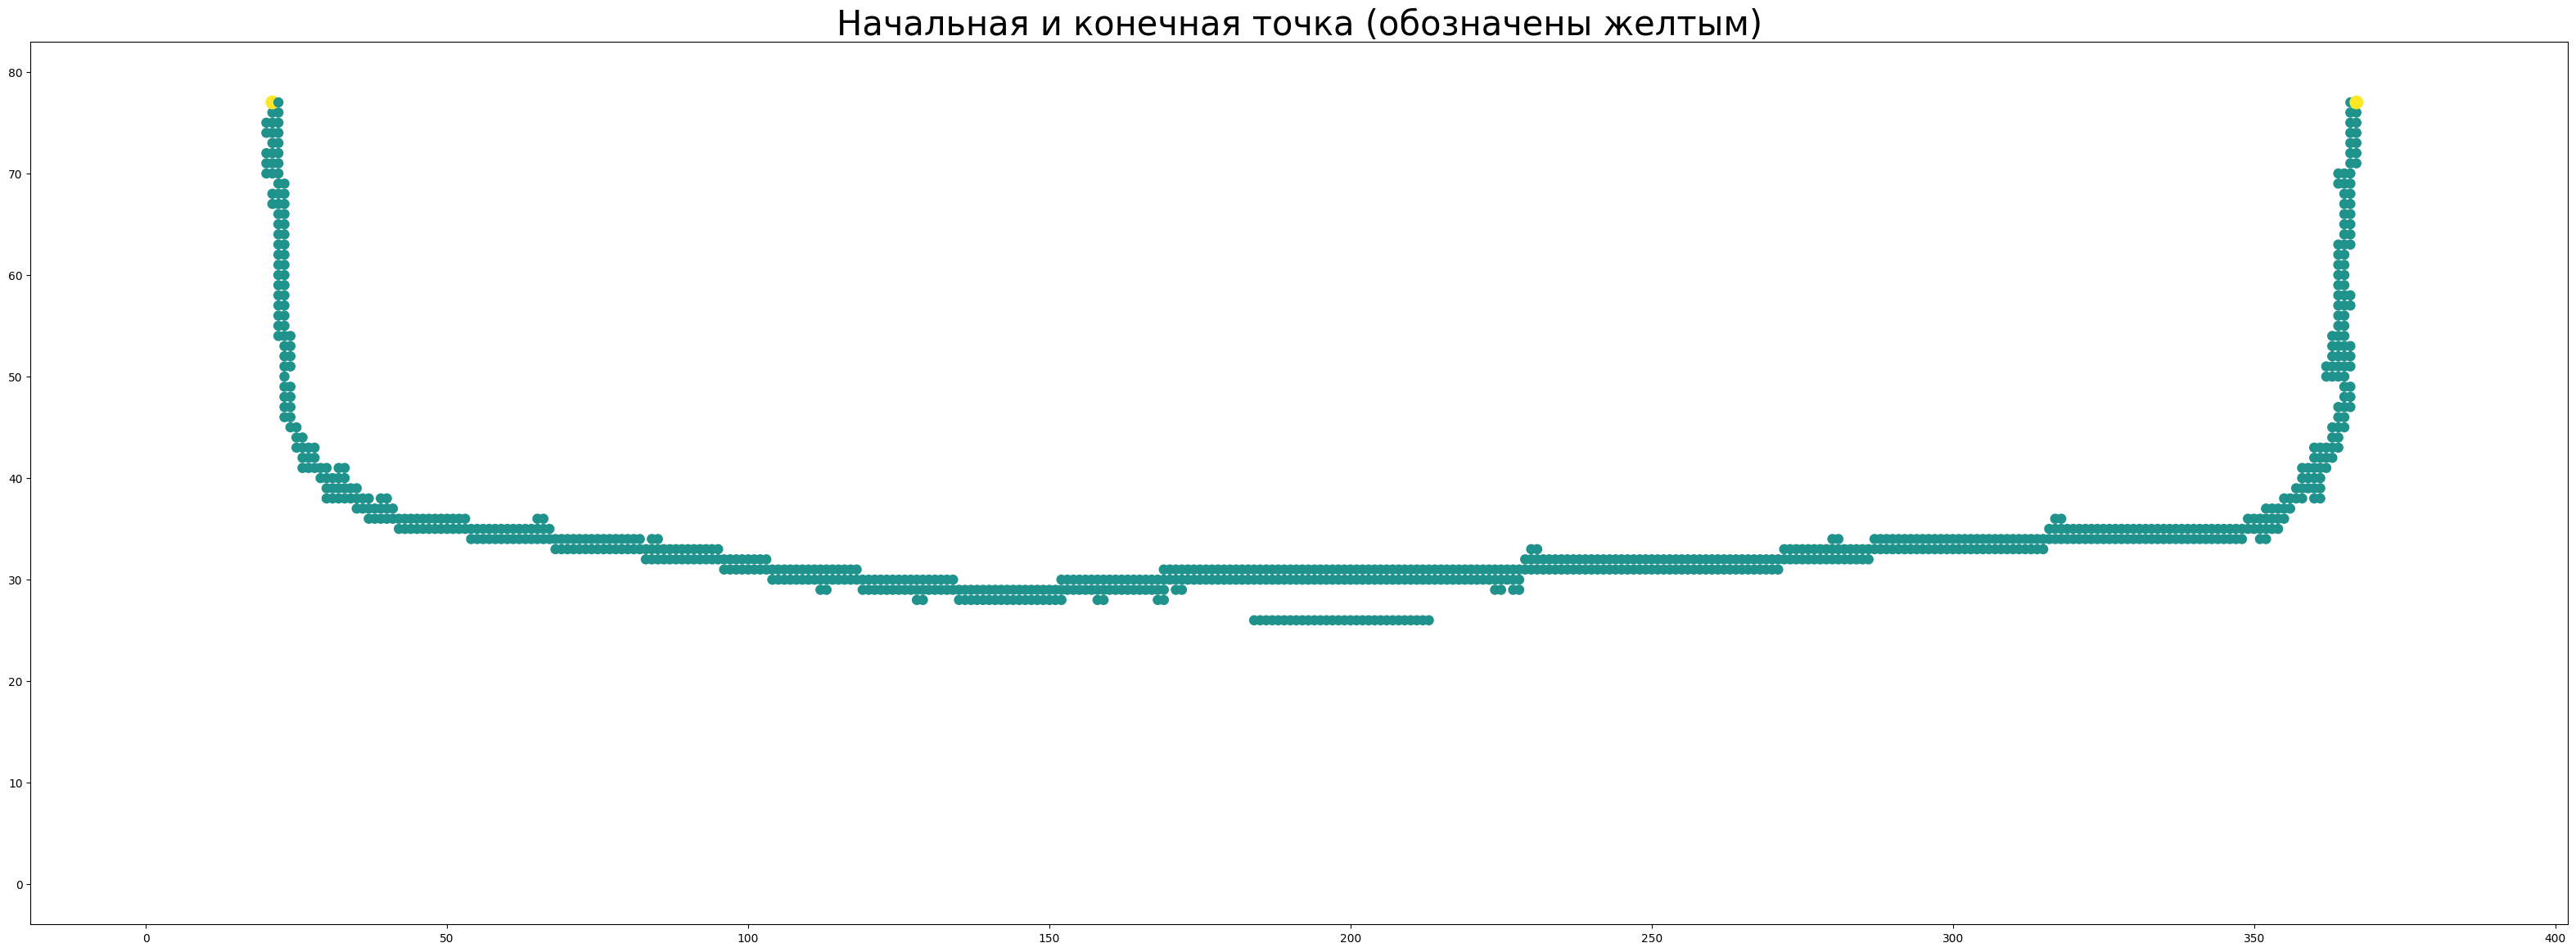

In [37]:
start_point, stop_point = find_start_stop(result_image)
print('start point:', f'{start_point},', 'stop point:', start_point)
new_result = result_image[:]
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
for point in [start_point, stop_point]:
    visualization_data[point[0]][point[1]] = 500
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], c=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title('Начальная и конечная точка (обозначены желтым)', fontdict={'fontsize':30})
plt.plot()

# Для нахождения фронта попробуем использовать волновой алгоритм

In [38]:
class Edge:
    path_len = float('inf')
    position = ()
    neighbors = []

    def __init__(self, position, neighbors, path_len = float('inf')):
        self.position = position
        self.neighbors = neighbors[:]
        self.path_len = path_len

    def get_path_len(self) -> float:
        return self.path_len

    def get_neighbors(self) -> list[tuple]:
        return self.neighbors
    
    def get_position(self) -> tuple:
        return self.position
    
    def set_path_len(self, path_len):
        self.path_len = path_len

    # def add_neighbors(self, neighbor):
    #     self.neighbors.append(neighbor)

def initialization_wave(image_data: np.ndarray, start: tuple) -> dict:
    """
    Инициализация узлов для волнового алгоритма.
    Параметры:
        image_data (np.ndarray): входное изображение;
        start: list[int]: начальная точка.
    """
    edges_dict = dict()
    rows, cols = image_data.shape
    neibor_indexes = ((0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1))
    for row in range(rows):
        for col in range(cols):
            if image_data[row][col] == 0:
                neibors = []
                for index in neibor_indexes:
                    delta_row = row + index[0] 
                    delta_col = col + index[1]
                    if delta_col >= 0 and delta_col < cols and delta_row >= 0 and delta_row < rows and image_data[delta_row][delta_col] == 0:
                        neibors.append((delta_row, delta_col))
                if row == start[0] and col == start[1]:
                    edges_dict[(row, col)] = Edge(position=(row, col), neighbors=neibors, path_len=0)
                else:
                    edges_dict[(row, col)] = Edge(position=(row, col), neighbors=neibors)
    return edges_dict
            

def wave_algorithm(image_data: np.ndarray, start: tuple, stop: tuple, multiplier: float = 1, contur_pixels: bool = False) -> dict:
    """
    Выполнение волнового алгоритма.
    Параметры:
        image_data (np.ndarray): входное изображение;
        start (tuple): начальная точка;
        stop (tuple): конечная точка;
        multiplier (float): множитель, задающий соотношение между длиной пикселя и длинной в мм;
        contur_pixels (bool): Параметр, при значении True выводит все пиксели относящиеся к фронту.
    """
    from collections import deque
    queque = deque()

    edges_dict = initialization_wave(image_data=image_data, start=start)
    queque.append(edges_dict[start])
    
    while queque:
        current_edge = queque.pop()
        current_path_value = current_edge.get_path_len()
        neighbors = current_edge.get_neighbors()
        currecnt_position = current_edge.get_position()
        for dot in neighbors:
            if (dot[0] - currecnt_position[0]) * (dot[1] - currecnt_position[1]) == 0:
                if edges_dict[dot].get_path_len() > current_path_value + 1:
                   edges_dict[dot].set_path_len(current_path_value + 1)
                   queque.append(edges_dict[dot])
            else:
                if edges_dict[dot].get_path_len() > current_path_value + np.sqrt(2):
                   edges_dict[dot].set_path_len(current_path_value + np.sqrt(2))
                   queque.append(edges_dict[dot])

    # Обратное распространение волны
    
    final_pixels = [stop]
    initial_edge = edges_dict[stop]
    initial_len = initial_edge.get_path_len()
    while initial_len > 0:
        neighbors = initial_edge.get_neighbors()
        min_len = initial_len
        for neighbor in neighbors:
            if edges_dict[neighbor].get_path_len() < min_len:
                min_len = edges_dict[neighbor].get_path_len()
                initial_edge = edges_dict[neighbor]
        initial_len = min_len
        final_pixels.append(initial_edge.get_position())
    if contur_pixels:
        return [multiplier * edges_dict[stop].get_path_len(), final_pixels]
    else:
        return multiplier * edges_dict[stop].get_path_len()

[]

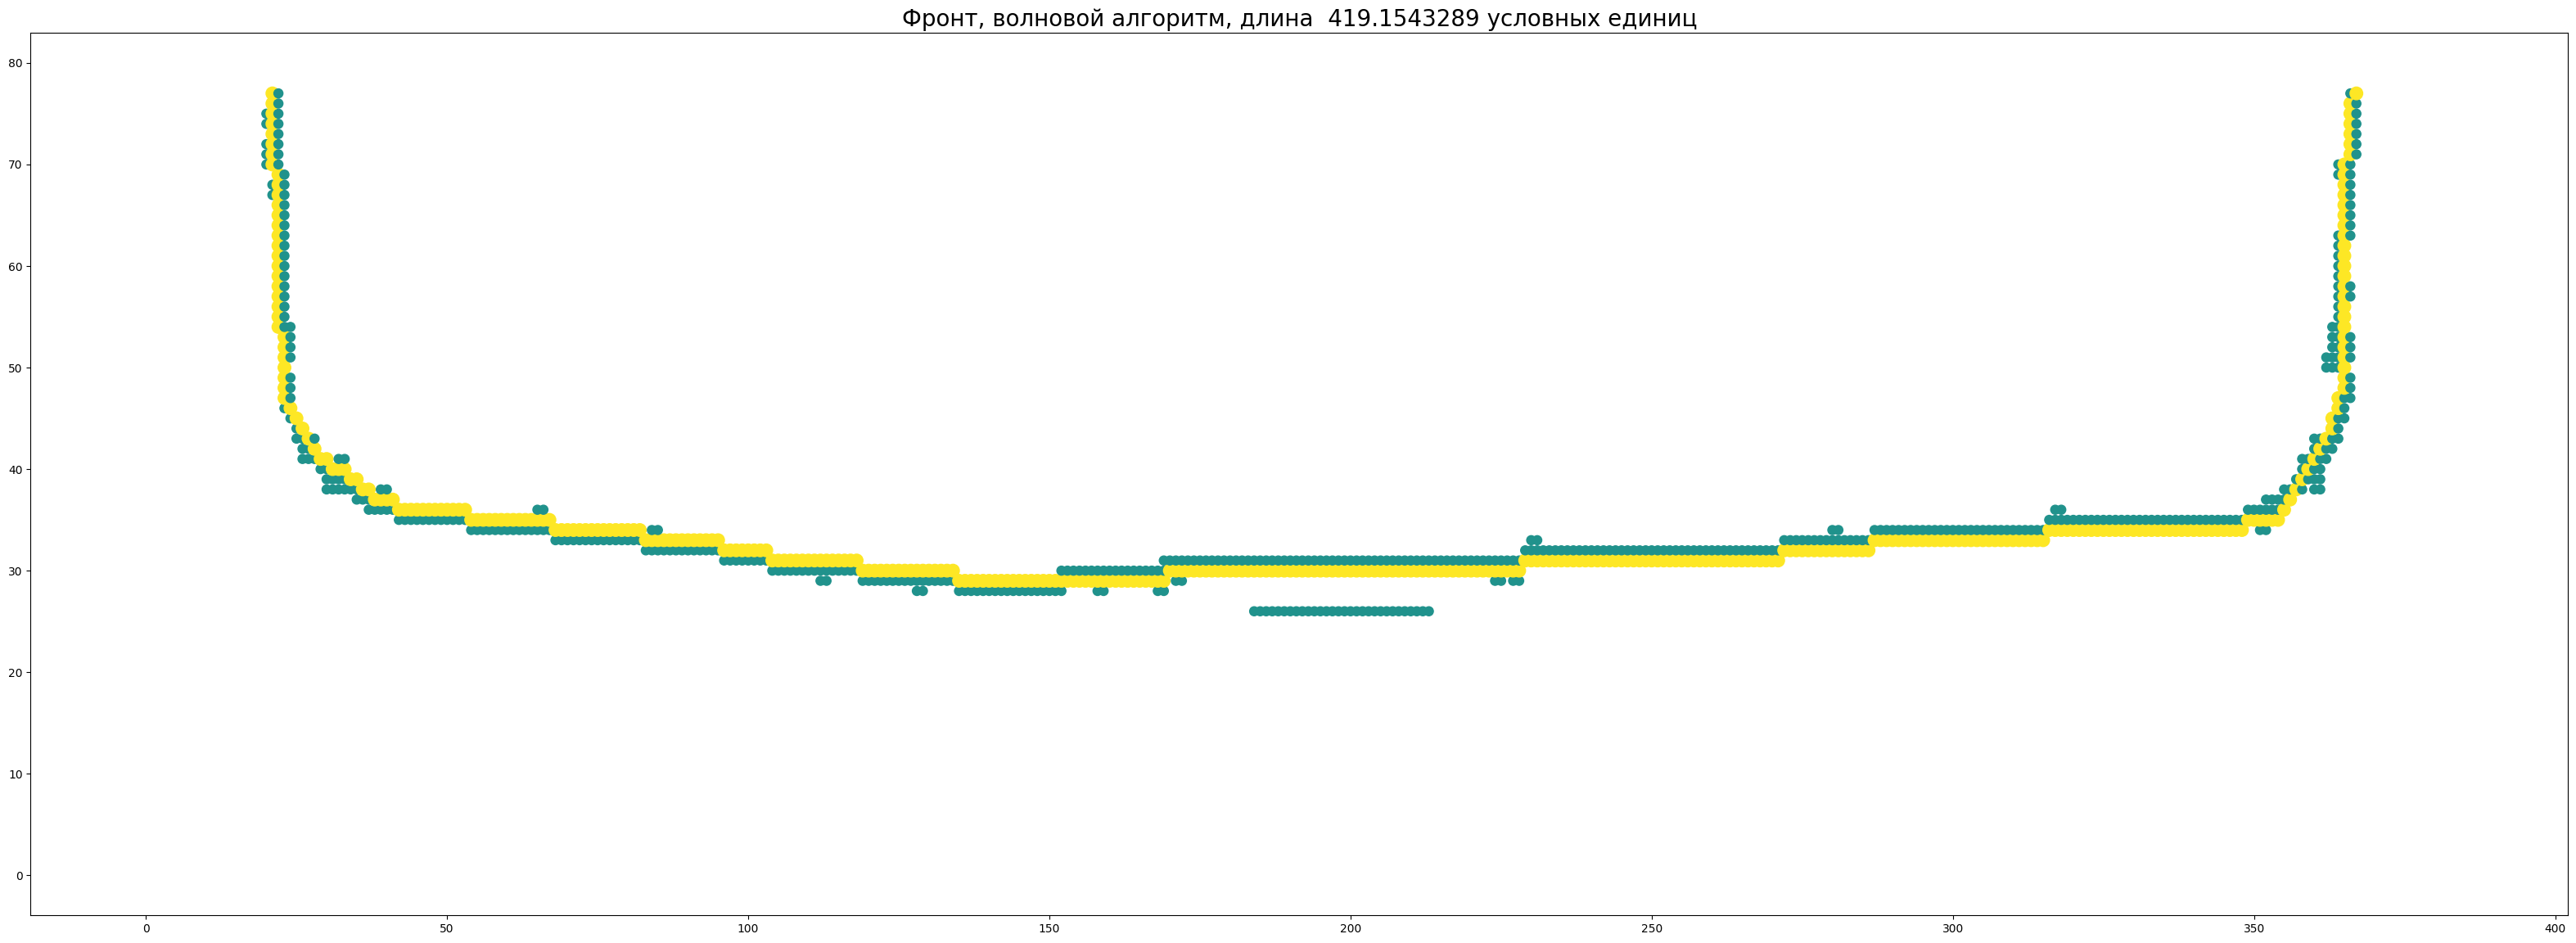

In [39]:
result_lenght, front_data = wave_algorithm(image_data=new_result, start=start_point, stop=stop_point, contur_pixels=True)
new_result = result_image[:]
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
for point in front_data:
    visualization_data[point[0]][point[1]] = 500
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], c=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title(f'Фронт, волновой алгоритм, длина {result_lenght: .7f} условных единиц', fontdict={'fontsize':20})
plt.plot()

# Для нахождения фронта попробуем обход по внешней стороне фронта

In [40]:
def neighbor_pixels(direction: tuple) -> list[tuple]:
    """
    Функция, возвращает соседей в зависимости от направления.
    Форма выходных данных: [row, col].
    Параметры:
        direction (tuple): предыдущее направление движения.
    """
    if direction[0] == 0:
        if direction[1] > 0:
            return [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (1, -1), (-1, -1)]
        else:
            return [(1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (1, 1), (-1, 1)]
    elif direction[0] > 0:
        return [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, -1), (-1, 1)] 
    else:
        return [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, 1), (1, -1)]

def external_contur(image_data: np.ndarray, start: tuple, stop: tuple, multiplier: float = 1, contur_pixels: bool = False) -> tuple:
    """
    Функция обхода по внешнему контуру.
    Возвращает последовательность точек внешнего конура.
    Параметры:
        image_data (np.ndarray): входное изображение;
        start (tuple): начальная точка;
        stop (tuple): конечная точка;
        multiplier (float): множитель, задающий соотношение между длиной пикселя и длинной в мм;
        contur_pixels (bool): Параметр, при значении True выводит все пиксели относящиеся к фронту.
    """
    current_direction = [(1, -1), (1, 0), (1, 1), (0, -1), (0, 1), (-1, -1), (-1, 1)]  # Начальный набор направлений

    pixel_dict = dict()
    rows, cols = image_data.shape

    for row in range(rows):
        for col in range(cols):
            if image_data[row][col] == 0:
                pixel_dict[(row, col)] = 1

    current_pixel = start
    pixel_dict[start] = 0
    final_pixels = [start]
    direct = (1, 0) # Промежуточная переменная для смены направления
    front_length = 0
    while current_pixel != stop:
        direction_flag = False
        for prom_direction in current_direction:
            x_delta = current_pixel[1] + prom_direction[1]
            y_delta = current_pixel[0] + prom_direction[0]
            if x_delta >= 0 and x_delta < cols and y_delta >= 0 and y_delta < rows and image_data[y_delta][x_delta] == 0 and pixel_dict[(y_delta, x_delta)] == 1:
                pixel_dict[(y_delta, x_delta)] = 0
                if prom_direction[0] * prom_direction[1] == 0:
                    direct = neighbor_pixels(direction=prom_direction)
                    direction_flag = True
                current_pixel = (y_delta, x_delta)
                final_pixels.append(current_pixel)
                break

        if direction_flag: # если идем по диагонале, то направление менять не надо, иначе меняем
            current_direction = direct
            front_length += np.sqrt(2)
        else:
            front_length += 1

    if contur_pixels:
        return [multiplier * front_length, final_pixels]
    return multiplier * front_length

[]

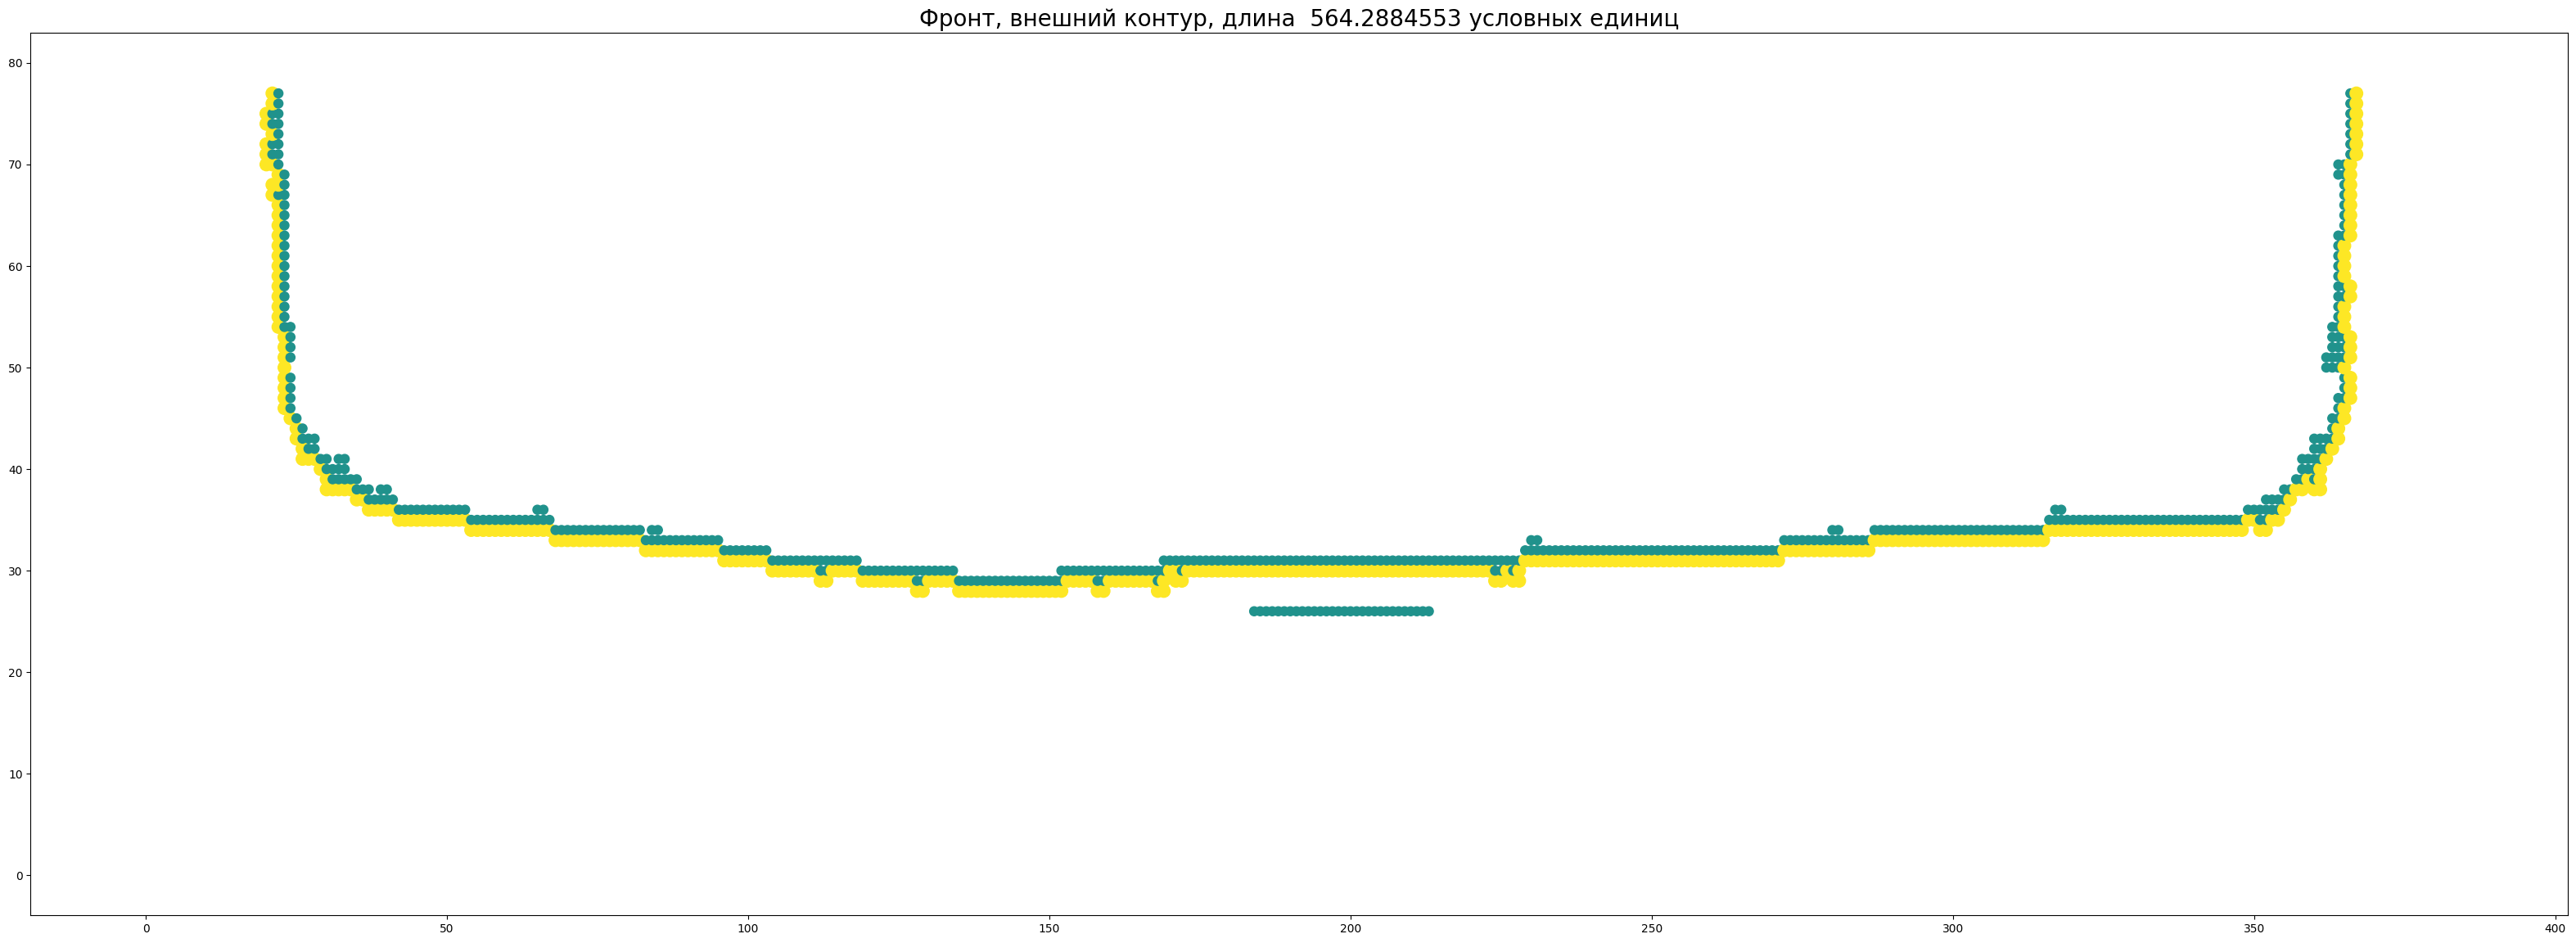

In [41]:
result_lenght, front_data = external_contur(image_data=new_result, start=start_point, stop=stop_point, contur_pixels=True)
new_result = result_image[:]
visualization_data = np.array([[0 if j == 255 else 255 for j in i]for i in result_image])
for point in front_data:
    visualization_data[point[0]][point[1]] = 500
y_range, x_range = result_image.shape
y_coords = np.arange(y_range)
x_coords = np.arange(x_range)
x_data, y_data = np.meshgrid(x_coords, y_coords)
figure, axis = plt.subplots(1, 1, figsize=(40, 14))
axis.scatter(x=x_data, y=y_data, s=visualization_data[len(visualization_data) - 1::-1], c=visualization_data[len(visualization_data) - 1::-1], marker ='.')
axis.set_title(f'Фронт, внешний контур, длина {result_lenght: .7f} условных единиц', fontdict={'fontsize':20})
plt.plot()